# Anomaly detection on the KDD Cup ‘99 dataset

This tutorial illustrates using Alibi for anomaly detection on the KDD Cup'99 dataset.
Each row in the dataset corresponds to a TCP connection, which belongs to a normal or attack type (binomial classification problem).

Attacks can be further categorized into four main types as follows, but we won't make it too complicated for now
+ **Denial of Service Attack (DOS):** denial-of-service, e.g. syn flood;
+ **Remote to Local Attack(R2L):** unauthorized access from a remote machine, e.g. `guessing password`;
+ **Users to Root Attack (U2R):**  unauthorized access to local superuser (root) privileges, e.g., various `buffer overflow` attacks;
+ **PROBE:** surveillance and other probing, e.g., port scanning.

Some references:
+ **Data:**
    + https://www.datasciencelovers.com/tag/network-intrusion-detection/
    + https://kdd.ics.uci.edu/databases/kddcup99/task.html
+ **Code:** https://docs.seldon.io/projects/alibi-detect/en/stable/examples/od_vae_kddcup.html

In [1]:
!pip install -r requirements.txt

  Using cached alibi-0.9.1-py3-none-any.whl.metadata (22 kB)
  Using cached alibi_detect-0.11.1-py3-none-any.whl.metadata (28 kB)
  Using cached blis-0.7.11-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
  Using cached scikit_image-0.19.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
  Using cached Pillow-9.5.0-cp39-cp39-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
  Using cached attrs-22.2.0-py3-none-any.whl.metadata (13 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.4 MB/s eta 0:00:00
  Using cached pydantic-1.10.17-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (151 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached numba-0.56.4-cp39-cp39-manylinux2014_x86

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alibi_detect import datasets
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.models.tensorflow import elbo
from alibi_detect.utils.visualize import plot_instance_score
from models.trainer import Trainer

2024-08-06 18:25:28.238409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 18:25:28.335495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-08-06 18:25:28.335511: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-06 18:25:28.353361: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 18:25:28.812197: 

In [3]:
# Fetch KDD Cup '99 dataset of computer network intrusions
intrusions = datasets.fetch_kdd()
print(intrusions.data.shape, intrusions.target.shape)

(494021, 18) (494021,)


## Constants

In [4]:
# Specify the weights folder to save weights for deployments
WEIGHTS_FOLDER = "./weights"

# Create the weights folder if not exists
if not os.path.exists(WEIGHTS_FOLDER):
    os.mkdir(WEIGHTS_FOLDER)

## EDA

In [5]:
# Inspect feature names
intrusions.feature_names

['srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

<AxesSubplot:>

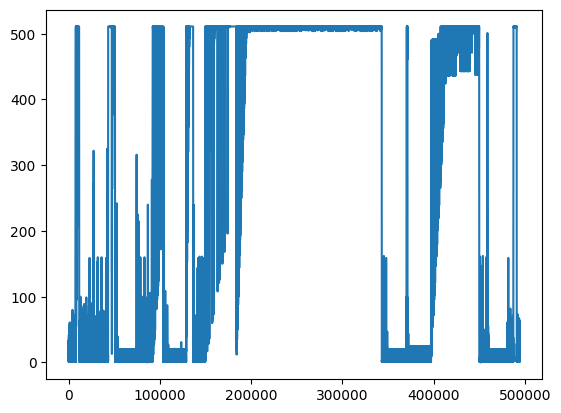

In [6]:
# Plot the first column of the dataset
pd.Series(intrusions['data'][:, 0]).plot()

In [7]:
# Convert intrusions to dataframe for processing
df = pd.DataFrame(intrusions['data'], columns=intrusions.feature_names)

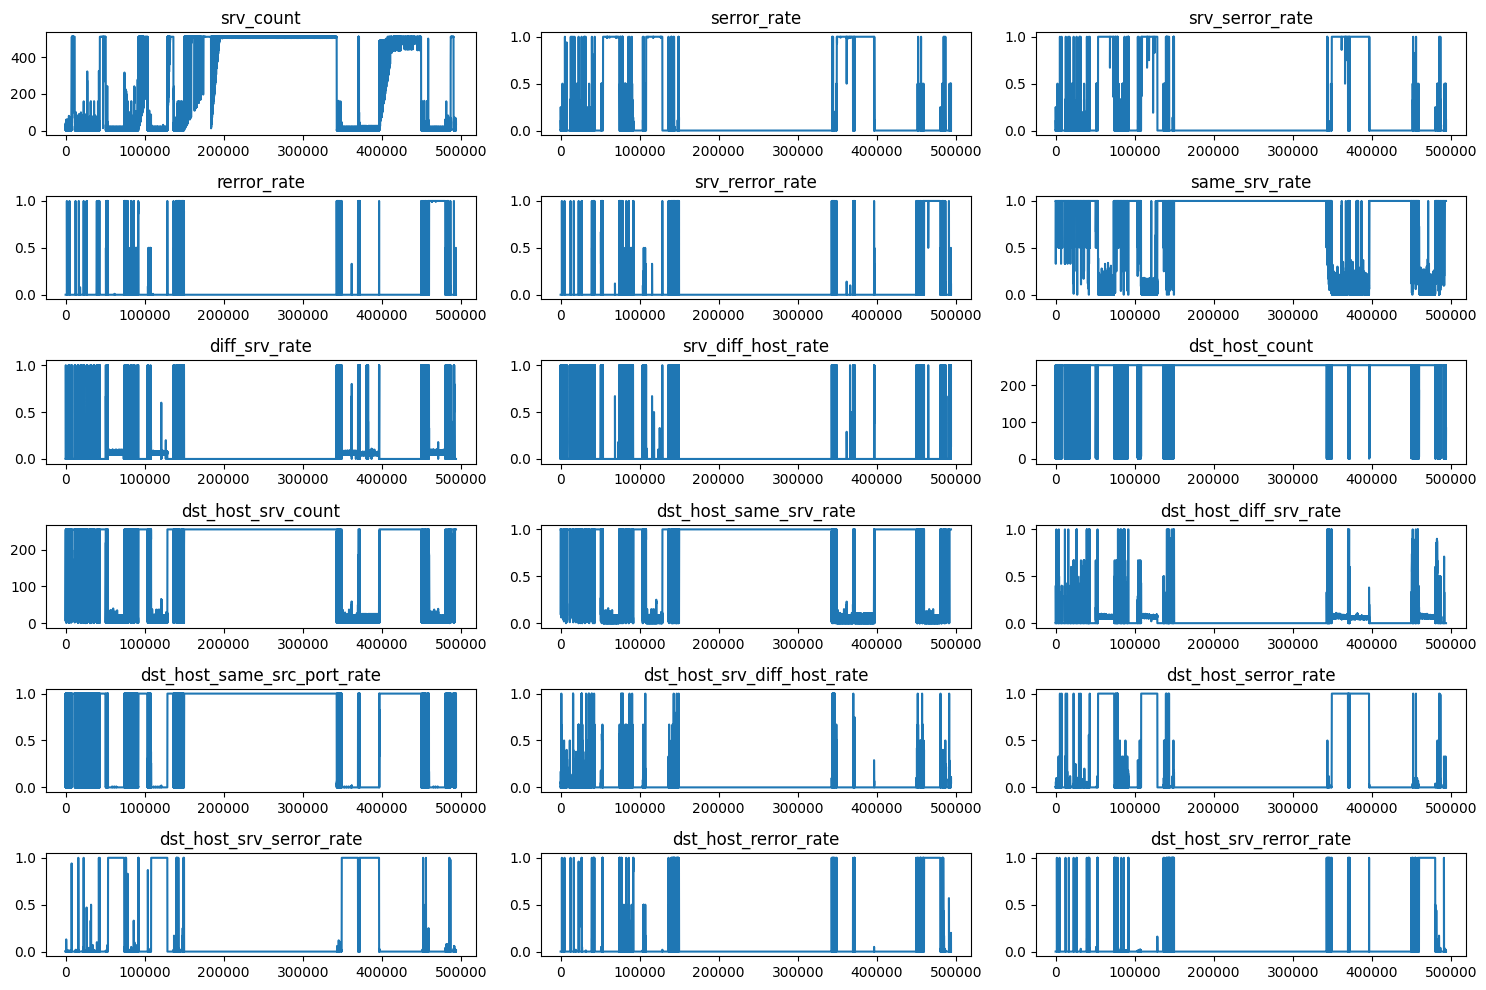

In [8]:
# Plot all columns to see where anomalies happen
# Please refer to this tutorial for more plots 
# https://pandas.pydata.org/pandas-docs/version/2.0.1/user_guide/visualization.html
nrows = 6
ncols = 3

# Set subplot shape and size 
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), tight_layout=True)

# Loop over each column to plot to subplot
for i in range(len(df.columns)):
    row_idx = i // ncols
    col_idx = i % ncols
    ax = axes[row_idx,col_idx]
    
    df.iloc[:,i].plot(ax=ax)
    ax.set_title(df.columns[i])

Before moving on, let's understand how boxplots can be used to detect outliers. An outlier is defined as a data point that is located outside the whiskers of the box plot. The n-th percentile is the value at which n percent of the data is below it.

![Box plot](./images/boxplot-outliers.png)

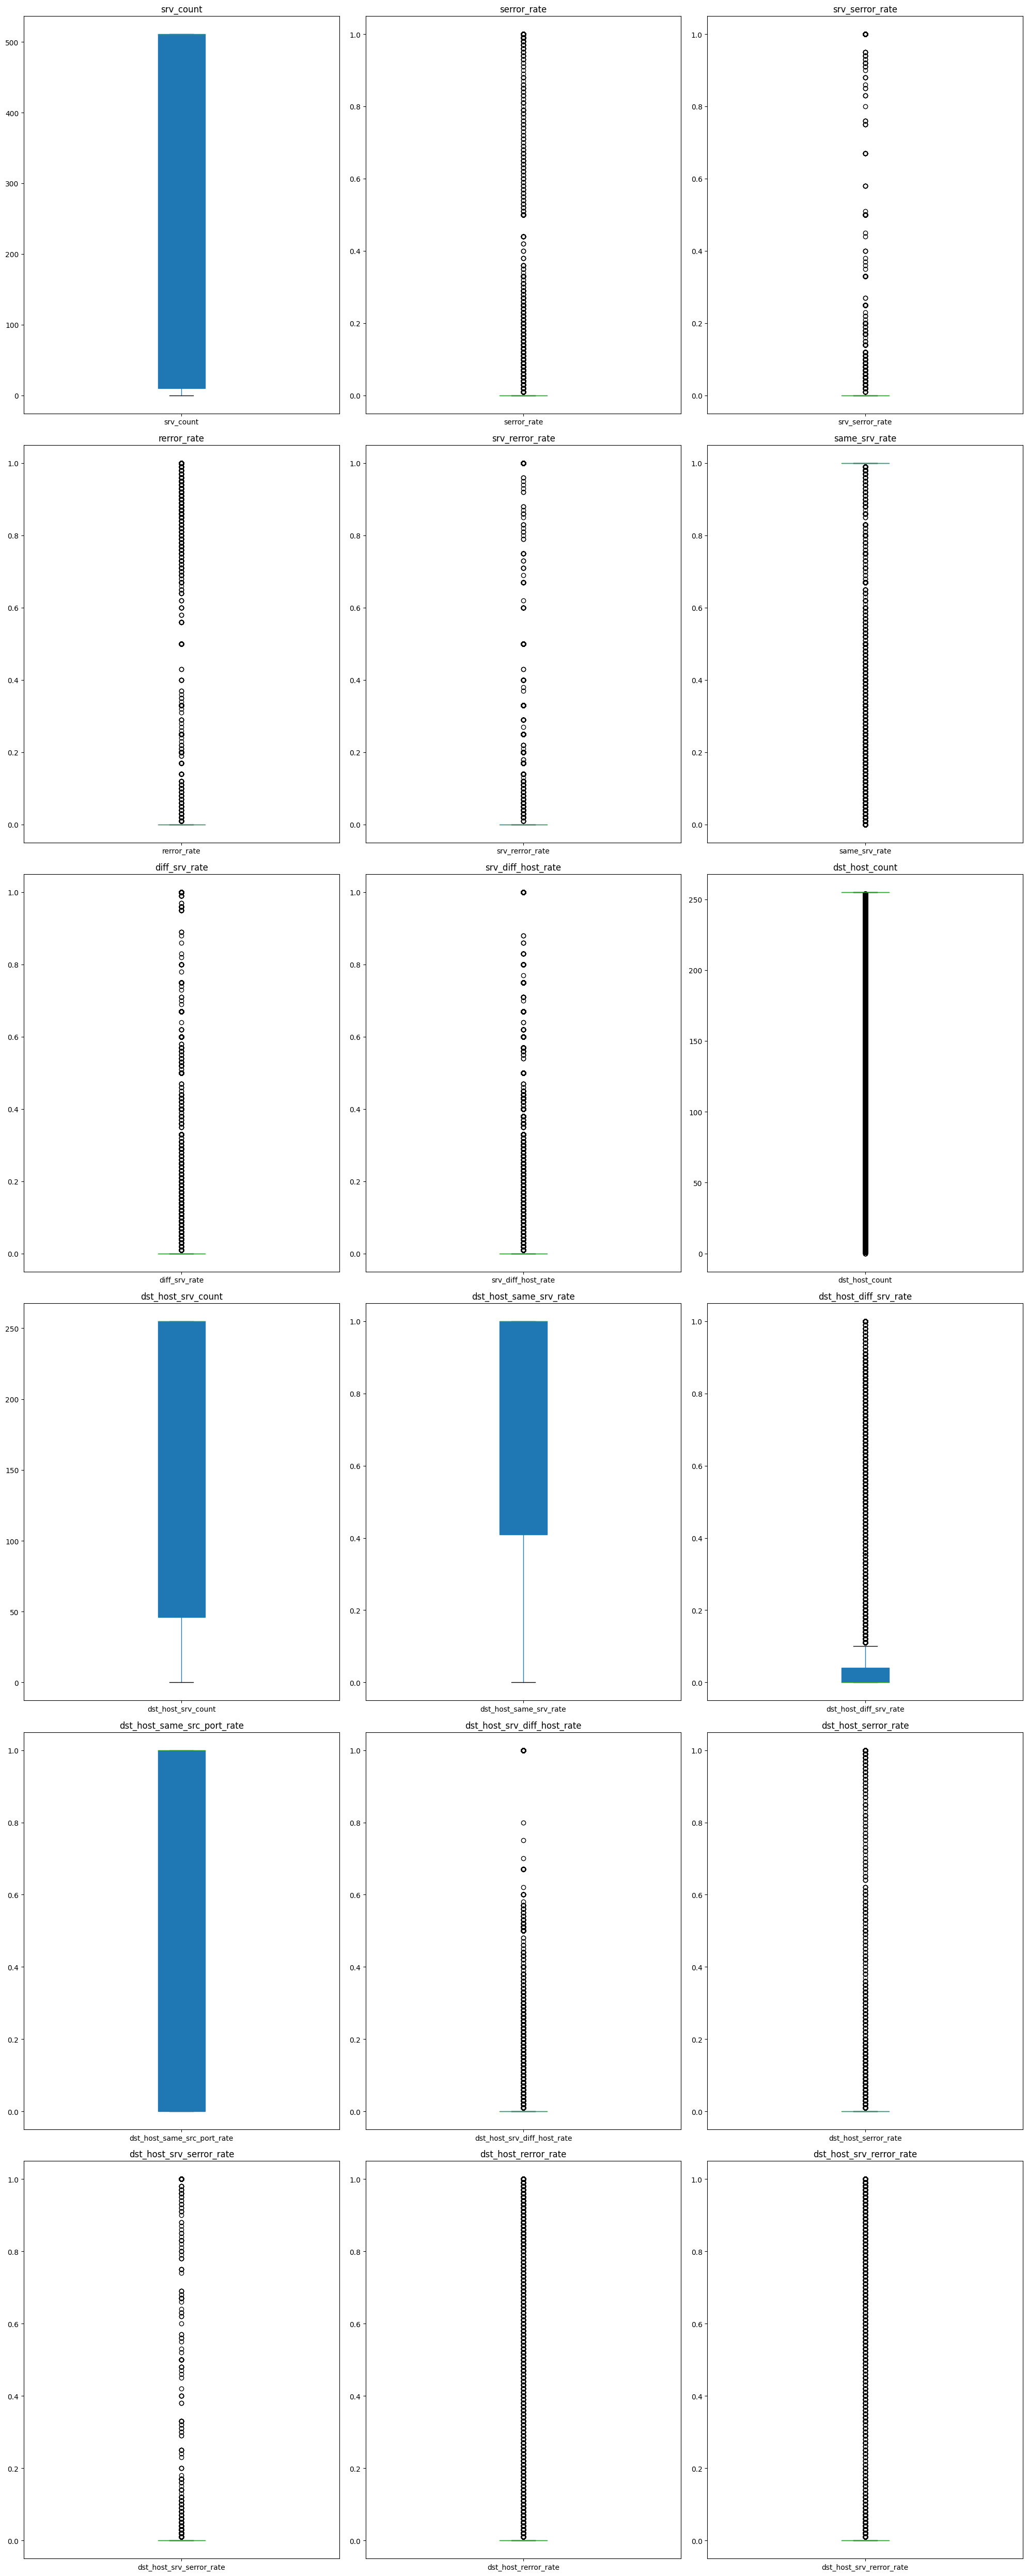

In [9]:
# Now, using box plots for better visualizations of anomalies
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 50), tight_layout=True)

# Loop over each column to plot to subplot
for i in range(len(df.columns)):
    row_idx = i // ncols
    col_idx = i % ncols
    ax = axes[row_idx,col_idx]
    
    df.iloc[:,i].plot.box(ax=ax, patch_artist=True)
    ax.set_title(df.columns[i])

From the above image, we can clearly see a large portion of data is abnormal.

In [10]:
# Investigate some stats from the data
df.describe(include='all')

,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021,494021.0,494021.0,494021.0,494021.0,494021.0,494021.0,494021.0,494021,494021,494021.0,494021.0,494021.0,494021.0,494021.0,494021.0,494021.0,494021.0
unique,470,92.0,51.0,77.0,51.0,99.0,78.0,64.0,256,256,101.0,101.0,101.0,65.0,100.0,72.0,101.0,101.0
top,511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
freq,226559,404787.0,405686.0,464948.0,464320.0,382079.0,382021.0,459377.0,432829,337746,347828.0,347031.0,288883.0,441889.0,399810.0,400945.0,458792.0,459805.0


## Prepare training data

In [11]:
# Set seed all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42)

In [12]:
# Create a normal batch for training, since labeling is expensive
# Refer to here for more details https://github.com/SeldonIO/alibi-detect/blob/master/alibi_detect/utils/data.py#L49
n_samples = 400000
normal_batch = create_outlier_batch(intrusions.data, intrusions.target, n_samples=n_samples, perc_outlier=0)

In [13]:
# Get features and target
X_train, y_train = normal_batch.data.astype(float), normal_batch.target

In [14]:
print(X_train[0].tolist())

[5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 255.0, 250.0, 0.98, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Training VAE and ISF

In [15]:
from models.trainer import Trainer
from alibi_detect.models.tensorflow import elbo

In [16]:
# Normalize X_train
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / stdev

In [17]:
# Model output path
vae_output_path = "weights/vae"

# Hyperparams for VAE
n_features = X_train.shape[1]
latent_dim = 2

vae_trainer = Trainer("vae", n_features, latent_dim)
vae_trainer.train(X_train,
        perc_outlier=5,
        loss_fn=elbo,
        cov_elbo=dict(sim=.01),
        epochs=1,
        verbose=True
)

# Save the model for prediction
vae_trainer.save_model(vae_output_path)

2024-08-06 18:25:43.098469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 18:25:43.104009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-08-06 18:25:43.104102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-08-06 18:25:43.104181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PA

6250/6250 [=] - 118s 19ms/step - loss_ma: 34838.9593


In [18]:
# Model output path
isf_output_path = "weights/isf"

isf_trainer = Trainer("isf")
isf_trainer.train(X_train, perc_outlier=5)

# Save the model for prediction
isf_trainer.save_model(isf_output_path)

## Evaluation

In [19]:
# Generate an evaluation batch, and create evaluation data
perc_outlier = 5
n_samples = 10000

# Create a batch of outlier for testing purposes
outlier_batch = create_outlier_batch(intrusions.data, intrusions.target, n_samples=n_samples, perc_outlier=perc_outlier)

# Get features and target
X_test, y_test = outlier_batch.data.astype(float), outlier_batch.target

# Normalize based on mean and stdev from the training set
X_test = (X_test - mean) / stdev

In [20]:
# Again, specify hyper-params to construct our network
n_features = X_train.shape[1]
latent_dim = 2

vae_trainer = Trainer("vae", n_features, latent_dim)
vae_trainer.load_model(vae_output_path)
vae_preds = vae_trainer.predict(
    X_test, outlier_type='instance', # use 'feature' or 'instance' level
    return_instance_score=True # Score used to determine outliers
)

print("VAE f1_score: ", vae_trainer.evaluate(y_test, vae_preds['data']['is_outlier'], "f1_score"))

No threshold level set. Need to infer threshold using `infer_threshold`.


VAE f1_score:  0.6789366053169735


In [21]:
# Again, specify hyper-params to construct our network
n_features = X_train.shape[1]
latent_dim = 2

isf_trainer = Trainer("isf", n_features, latent_dim)
isf_trainer.load_model(isf_output_path)
isf_preds = isf_trainer.predict(
                            pd.DataFrame(X_test),
                            return_instance_score=True
                           )

print("ISF f1_score: ", isf_trainer.evaluate(y_test, isf_preds['data']['is_outlier'], "f1_score"))

ISF f1_score:  0.2564102564102564


## Visualization

We plot the outlier scores at instance level and the threshold to identify outliers as follows

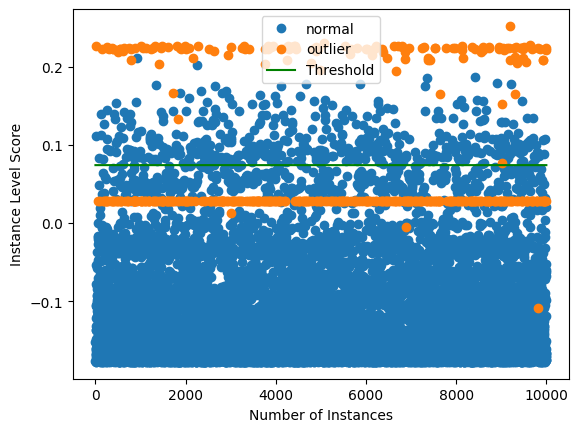

In [22]:
# Plot ISF, we clearly see its performance is not so good. 
# To be more specific, lots of outliers are still below the threshold
plot_instance_score(
    preds=isf_preds,
    target=y_test,
    labels=outlier_batch.target_names,
    threshold=isf_trainer.model.threshold
)

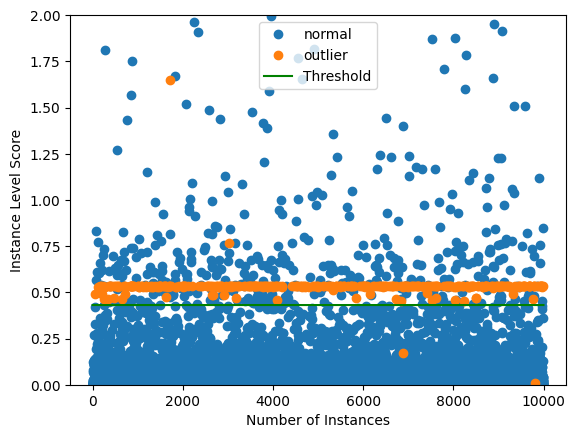

In [23]:
# Plot VAE, the situation is now better. 
# Most of the outliers are above the threshold. 
plot_instance_score(
    preds=vae_preds,
    target=y_test,
    labels=outlier_batch.target_names,
    threshold=vae_trainer.model.threshold,
    ylim=(0,2)
)

## Conclusion

Now, try to improve this by selecting other algorithms such as SR-CNN and TranAD (from DeepOD) or others from alibi.